# 2022 World Cup Champion Prediction

#### Group Members:
#### Bijin Zhang (Iris), Yi Zheng (Zoey), Youjing Shen (Simona)


## Import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 1. Data Preprocessing
### Load Data

In [2]:
# Read all data

# Records of international matches (all kinds of matches) from 1872 to 27/09/2022
international_matches = pd.read_csv('international_matches.csv')

# Records of world cup matches from 1930 to 15/07/2018
world_cup_matches = pd.read_csv('world_cup_matches.csv')

# Records of each world cup final information from 1930 to 2018
# Iincluding Host Country, Winner, Runners-Up, Third, Fourth, Goals Scored, Qualified Teams, Matches Played
world_cup_results = pd.read_csv('world_cups.csv')

# FIFA Ranking of 32 teams in 2022 World Cup
ranking_2022 = pd.read_csv('2022_world_cup_groups.csv')

# 2022 World Cup matches information
# Including Year, Date, Stage, Home Team, Away Team, Host Team
matches_2022 = pd.read_csv('2022_world_cup_matches.csv')

In [3]:
# A function helps to rename columns
def rename_columns(df):
    df.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)

In [4]:
# Apply the function to each DataFrame
rename_columns(international_matches)
rename_columns(world_cup_matches)
rename_columns(world_cup_results)
rename_columns(ranking_2022)
rename_columns(matches_2022)

In [5]:
international_matches.head()

,id,tournament,date,home_team,home_goals,away_goals,away_team,win_conditions,home_stadium
0,1,Friendly,1872-11-30,Scotland,0,0,England,NaN,True
1,2,Friendly,1873-03-08,England,4,2,Scotland,NaN,True
2,3,Friendly,1874-03-07,Scotland,2,1,England,NaN,True
3,4,Friendly,1875-03-06,England,2,2,Scotland,NaN,True
4,5,Friendly,1876-03-04,Scotland,3,0,England,NaN,True


In [6]:
world_cup_matches.head()

,id,year,date,stage,home_team,home_goals,away_goals,away_team,win_conditions,host_team
0,1,1930,1930-07-13,Group stage,France,4,1,Mexico,NaN,False
1,2,1930,1930-07-13,Group stage,United States,3,0,Belgium,NaN,False
2,3,1930,1930-07-14,Group stage,Yugoslavia,2,1,Brazil,NaN,False
3,4,1930,1930-07-14,Group stage,Romania,3,1,Peru,NaN,False
4,5,1930,1930-07-15,Group stage,Argentina,1,0,France,NaN,False


In [7]:
world_cup_results.head()

,year,host_country,winner,runners-up,third,fourth,goals_scored,qualified_teams,matches_played
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70.0,13,18
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70.0,16,17
2,1938,France,Italy,Hungary,Brazil,Sweden,84.0,15,18
3,1950,Brazil,Uruguay,Brazil,Sweden,Spain,88.0,13,22
4,1954,Switzerland,Germany FR,Hungary,Austria,Uruguay,140.0,16,26


In [8]:
ranking_2022.head()

,group,team,fifa_ranking
0,A,Qatar,50
1,A,Ecuador,44
2,A,Senegal,18
3,A,Netherlands,8
4,B,England,5


In [9]:
matches_2022.head()

,id,year,date,stage,home_team,away_team,host_team
0,1,2022,2022-11-20,Group stage,Qatar,Ecuador,True
1,2,2022,2022-11-21,Group stage,Senegal,Netherlands,False
2,3,2022,2022-11-21,Group stage,England,Iran,False
3,4,2022,2022-11-21,Group stage,United States,Wales,False
4,5,2022,2022-11-22,Group stage,France,Australia,False


### Create dataframes (2-step)
#### Create dataframe "all_matches" concatenating international_matches and world_cup_matches
This step selects certain columns needed from two DataFrames, adds a new column to each to indicate whether the match is a world cup match or not, concatenates them, and processes the dates to extract the year. Add new column 'result'.

In [10]:
# Columns to select
columns = ['date', 'home_team', 'home_goals', 'away_goals', 'away_team']

# Selecting columns, and adding 'world_cup_matches' column using 'assign'
international_matches_df = international_matches[columns].assign(wcm=0)
world_cup_matches_df = world_cup_matches[columns].assign(wcm=1)

# Concatenating DataFrames
all_matches = pd.concat([international_matches_df, world_cup_matches_df])

# Resetting index and extracting the year from the date
all_matches = all_matches.reset_index(drop=True)
all_matches['year'] = pd.to_datetime(all_matches['date']).dt.year

# Because the World Cup started from year 1930
# Dropping unnecessary columns and filtering rows based on year
all_matches = all_matches.drop(['date'], axis=1)
all_matches = all_matches[all_matches['year'] >= 1930]

# Ensuring 'year' is of integer type
all_matches['year'] = all_matches['year'].astype(int)


In [11]:
all_matches = all_matches.reset_index()

In [12]:
# Create new variable 'result' for the last column
# 1 - win, 2 - tie, 3 - loss
result_list = [
    (all_matches['home_goals'] > all_matches['away_goals']),  # Home team wins
    (all_matches['home_goals'] < all_matches['away_goals']),  # Home team loses
    (all_matches['home_goals'] == all_matches['away_goals'])  # Tie
]

status_list = [1, 3, 2]  # Corresponding choices for win, loss, tie

# Fill the 'result' column with corresponding conditions
all_matches['result'] = np.select(result_list, status_list)

In [13]:
# Display the shape and head of the DataFrame
print(all_matches.shape)
all_matches.head()

(17812, 8)


,index,home_team,home_goals,away_goals,away_team,wcm,year,result
0,857,Spain,1,0,Czechoslovakia,0,1930,1
1,858,Portugal,1,0,Czechoslovakia,0,1930,1
2,859,Northern Ireland,7,0,Wales,0,1930,1
3,860,Italy,4,2,Switzerland,0,1930,1
4,861,Portugal,2,0,France,0,1930,1


### Create dataframes "countries"

The following step extracts unique country names from 'home_team' and 'away_team' columns of two DataFrames (international_matches and world_cup_matches), and then combine them into a single list of unique countries. After that, it creates a DataFrame from this list and sets the index of the DataFrame to be the country names themselves. After we have the country list, we'll continue creating the dataset that has the matches.

In [14]:
# Function to get unique countries from a DataFrame
def get_unique_countries(df):
    return np.union1d(df['home_team'], df['away_team'])

In [15]:
# Get unique countries from both DataFrames
countries_international = get_unique_countries(international_matches)
countries_world_cup = get_unique_countries(world_cup_matches)

# Combine and get unique countries from both lists
all_countries = np.union1d(countries_international, countries_world_cup)

# Create a DataFrame from the list of countries
countries = pd.DataFrame(index=all_countries)

In [16]:
countries.head()

""
Afghanistan
Albania
Algeria
American Samoa
Andalusia


In [17]:
# Function to calculate match statistics for a DataFrame
def calculate_match_stats(df, countries_df, prefix):
    # Total Matches Played
    matches_played = df.groupby(['home_team']).size() + df.groupby(['away_team']).size()
    countries_df[prefix + '_match'] = matches_played.reindex(countries_df.index).fillna(0).astype(int)

    # Won Matches
    home_wins = df[df['home_goals'] > df['away_goals']].groupby(['home_team']).size()
    away_wins = df[df['home_goals'] < df['away_goals']].groupby(['away_team']).size()
    countries_df[prefix + '_match_won'] = (home_wins + away_wins).reindex(countries_df.index).fillna(0).astype(int)

    # Lost Matches
    home_losses = df[df['home_goals'] < df['away_goals']].groupby(['home_team']).size()
    away_losses = df[df['home_goals'] > df['away_goals']].groupby(['away_team']).size()
    countries_df[prefix + '_match_lost'] = (home_losses + away_losses).reindex(countries_df.index).fillna(0).astype(int)

    # Tied Matches
    ties = df[df['home_goals'] == df['away_goals']].groupby(['home_team']).size() + df[df['home_goals'] == df['away_goals']].groupby(['away_team']).size()
    countries_df[prefix + '_match_tied'] = ties.reindex(countries_df.index).fillna(0).astype(int)

    return countries_df

In [18]:
# Apply the function for international matches
countries = calculate_match_stats(international_matches, countries, 'inter')

In [19]:
# International Matches Goals
# Calculating scored and conceded goals can be:

# Scored Goals
scored_home = international_matches.groupby('home_team')['home_goals'].sum()
scored_away = international_matches.groupby('away_team')['away_goals'].sum()
countries['inter_goals_sco'] = (scored_home + scored_away).reindex(countries.index).fillna(0).astype(int)

# Conceded Goals
conceded_home = international_matches.groupby('home_team')['away_goals'].sum()
conceded_away = international_matches.groupby('away_team')['home_goals'].sum()
countries['inter_goals_con'] = (conceded_home + conceded_away).reindex(countries.index).fillna(0).astype(int)

In [20]:
# Apply the function for World Cup matches
countries = calculate_match_stats(world_cup_matches, countries, 'wc')

In [21]:
# World Cup Matches Goals
# Calculating scored and conceded goals can be:

# Scored Goals in World Cup
scored_home_wc = world_cup_matches.groupby('home_team')['home_goals'].sum()
scored_away_wc = world_cup_matches.groupby('away_team')['away_goals'].sum()
countries['wc_goals_sco'] = (scored_home_wc + scored_away_wc).reindex(countries.index).fillna(0).astype(int)

# Conceded Goals in World Cup
conceded_home_wc = world_cup_matches.groupby('home_team')['away_goals'].sum()
conceded_away_wc = world_cup_matches.groupby('away_team')['home_goals'].sum()
countries['wc_goals_con'] = (conceded_home_wc + conceded_away_wc).reindex(countries.index).fillna(0).astype(int)


In [22]:
print(countries.shape)
countries.head(20)

(227, 12)


,inter_match,inter_match_won,inter_match_lost,inter_match_tied,inter_goals_sco,inter_goals_con,wc_match,wc_match_won,wc_match_lost,wc_match_tied,wc_goals_sco,wc_goals_con
Afghanistan,10,0,9,0,2,41,0,0,0,0,0,0
Albania,93,10,69,14,54,196,0,0,0,0,0,0
Algeria,146,52,53,41,156,162,13,3,7,3,13,19
American Samoa,0,0,0,0,0,0,0,0,0,0,0,0
Andalusia,0,0,0,0,0,0,0,0,0,0,0,0
Andorra,43,0,43,0,5,155,0,0,0,0,0,0
Angola,50,6,26,18,36,75,3,0,0,0,1,2
Antigua and Barbuda,2,0,2,0,2,5,0,0,0,0,0,0
Argentina,929,503,190,236,1738,949,81,43,23,15,137,93
Armenia,58,4,45,9,31,131,0,0,0,0,0,0


### Calculate the differences in various match statistics (like total matches played, matches won, goals scored, etc.) between the home and away teams for each match.

In [23]:
# Define a function to calculate differences in statistics
def calculate_stat_difference(all_matches_df, countries_df, stat):
    home_stats = countries_df.reindex(all_matches_df['home_team'])[stat].values
    away_stats = countries_df.reindex(all_matches_df['away_team'])[stat].values
    return home_stats - away_stats

# List of statistics for which differences need to be calculated
stat_list = ['inter_match', 'inter_match_won', 'inter_match_lost', 'inter_match_tied',
             'inter_goals_sco', 'inter_goals_con', 'wc_match', 'wc_match_won',
             'wc_match_lost', 'wc_match_tied', 'wc_goals_sco', 'wc_goals_con']

# Apply the function for each statistic
for stat in stat_list:
    all_matches['dif_' + stat] = calculate_stat_difference(all_matches, countries, stat)

# Drop the 'dif_inter_match_tie' column (there are two columns)
if 'dif_inter_match_tie' in all_matches.columns:
    all_matches.drop('dif_inter_match_tie', axis=1, inplace=True)

In [24]:
# Print the first few rows of the DataFrame to verify the changes
print(all_matches.shape)
all_matches.head()

(17812, 20)


,index,home_team,home_goals,away_goals,away_team,wcm,year,result,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tied,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con
0,857,Spain,1,0,Czechoslovakia,0,1930,1,488,315,60,113,1061,346,33,19,18,10,55,27
1,858,Portugal,1,0,Czechoslovakia,0,1930,1,438,222,113,103,748,466,0,3,10,1,5,-10
2,859,Northern Ireland,7,0,Wales,0,1930,1,-373,-164,-136,-73,-544,-409,8,3,5,0,9,19
3,860,Italy,4,2,Switzerland,0,1930,1,-438,-120,-259,-59,-595,-936,46,33,0,13,78,13
4,861,Portugal,2,0,France,0,1930,1,-191,-101,-61,-29,-388,-353,-36,-20,-9,-7,-71,-42


In [25]:
# Define the desired column order, remove 'index' and 'year' columns
column_order = ['home_team', 'home_goals', 'away_goals', 'away_team', 'wcm',
                'dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost',
                'dif_inter_match_tied', 'dif_inter_goals_sco', 'dif_inter_goals_con',
                'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost',
                'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con',
                'result']

# Reorder the DataFrame columns
all_matches = all_matches[column_order]

In [26]:
print(all_matches.shape)
all_matches.head(10)

(17812, 18)


,home_team,home_goals,away_goals,away_team,wcm,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tied,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con,result
0,Spain,1,0,Czechoslovakia,0,488,315,60,113,1061,346,33,19,18,10,55,27,1
1,Portugal,1,0,Czechoslovakia,0,438,222,113,103,748,466,0,3,10,1,5,-10,1
2,Northern Ireland,7,0,Wales,0,-373,-164,-136,-73,-544,-409,8,3,5,0,9,19,1
3,Italy,4,2,Switzerland,0,-438,-120,-259,-59,-595,-936,46,33,0,13,78,13,1
4,Portugal,2,0,France,0,-191,-101,-61,-29,-388,-353,-36,-20,-9,-7,-71,-42,1
5,Germany,0,2,Italy,0,517,343,106,68,1402,629,26,22,5,-1,98,48,3
6,France,3,3,Switzerland,0,12,120,-106,-2,269,-264,29,22,2,5,70,13,2
7,England,5,2,Scotland,0,558,393,29,136,1538,362,46,25,7,14,66,23,1
8,Netherlands,1,1,Italy,0,411,230,125,56,1032,573,-33,-18,-6,-9,-42,-29,2
9,France,1,6,Belgium,0,53,68,-28,13,78,-104,18,14,0,4,52,5,3


## 2. Train the classification model

In [27]:
# Set X and y
X = all_matches.drop(columns=['home_team','home_goals','away_goals', 'away_team', 'result'], axis=1)
y = all_matches[['result']]
y = y.astype(int)

In [28]:
from sklearn.model_selection import train_test_split
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

### 2.1 Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion="entropy", max_depth = 8).fit(X_train,y_train)
y_pred_tree = tree.predict(X_test)

#### Conduct Cross-Validation and Grid Search for Hyperparameter Tuning

In [30]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, 10, None],  # None means max depth not constrained
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Create a decision tree classifier object
dt = DecisionTreeClassifier()

# Create a GridSearchCV object
# Searches this grid of parameters, performing 5-fold cross-validation for each combination.
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Retrieve the best estimator (model)
best_tree = grid_search.best_estimator_

# Evaluate the best model using the test set
y_pred = best_tree.predict(X_test)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           1       0.60      0.81      0.69      2589
           2       0.25      0.00      0.00      1316
           3       0.47      0.59      0.52      1439

    accuracy                           0.55      5344
   macro avg       0.44      0.47      0.40      5344
weighted avg       0.48      0.55      0.47      5344



####  Continue to experiment with hyperparameter tuning

In [31]:
# Expanding the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 4, 6, 8, 10, 12, 15, 20],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'class_weight': [None, 'balanced']
}

# Create a decision tree classifier object
dt = DecisionTreeClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Retrieve the best estimator (model)
best_tree = grid_search.best_estimator_

# Evaluate the best model using the test set
y_pred = best_tree.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


KeyboardInterrupt: ignored

#### Display the output

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Confusion matrix display
labels_=['WIN', 'TIE', 'LOSE']
cm_tree = confusion_matrix(y_test, y_pred_tree, labels = tree.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree,display_labels=labels_)
disp_tree.plot(cmap='RdBu')
for text in disp_tree.text_:
    for t in text:
        t.set_color('white')
plt.show()

print((classification_report(y_test, y_pred_tree)))

### 2.2 Logistic Regression

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

#### Model Training and Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Define the parameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],  # Use 'lbfgs' solver for faster convergence
    'max_iter': [1000, 2000, 3000, 4000, 5000],
}

# Create a Logistic Regression classifier object
lr = LogisticRegression()

# Create a GridSearchCV object
lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Standardize the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the grid search to the data
lr_grid_search.fit(X_scaled, y.ravel())

# Print the best parameters
print("Best parameters found for Logistic Regression: ", lr_grid_search.best_params_)

# Retrieve the best estimator (model)
best_lr = LogisticRegression(**lr_grid_search.best_params_)


#### Model Evaluation and Display the output

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Fit the best estimator on the entire training set
best_lr.fit(X_scaled, y.ravel())

# Evaluate the best Logistic Regression model using the test set
X_test_scaled = scaler.transform(X_test)
y_pred_lr_best = best_lr.predict(X_test_scaled)

# Confusion matrix display
cm_lr_best = confusion_matrix(y_test, y_pred_lr_best, labels=best_lr.classes_)
disp_lr_best = ConfusionMatrixDisplay(confusion_matrix=cm_lr_best, display_labels=labels_)
disp_lr_best.plot(cmap='RdBu')
for text in disp_lr_best.text_:
    for t in text:
        t.set_color('white')
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred_lr_best))

### 2.3 Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
rf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.61      0.75      0.67      2589
           2       0.30      0.18      0.22      1316
           3       0.49      0.47      0.48      1439

    accuracy                           0.53      5344
   macro avg       0.46      0.46      0.46      5344
weighted avg       0.50      0.53      0.51      5344



Cross-Validation and Hyperparameter Tuning

In [33]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Assuming X is your feature set and y is the label
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest Classifier model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
#param_grid = {
    #'n_estimators': [100, 200, 300],  # Number of trees in the forest
    #'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    #'max_depth': [4, 6, 8, None],  # Maximum depth of the tree
    #'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    #'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
#}

param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [8],  # Maximum depth of the tree
    'min_samples_split': [10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [4]  # Minimum number of samples required at each leaf node
}

# Create a GridSearchCV object for cross-validation and parameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Use the best model found for prediction on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Print the classification report for model evaluation
print(classification_report(y_test, y_pred))



Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           1       0.61      0.82      0.70      2593
           2       0.43      0.02      0.03      1266
           3       0.48      0.59      0.53      1485

    accuracy                           0.57      5344
   macro avg       0.51      0.48      0.42      5344
weighted avg       0.53      0.57      0.50      5344



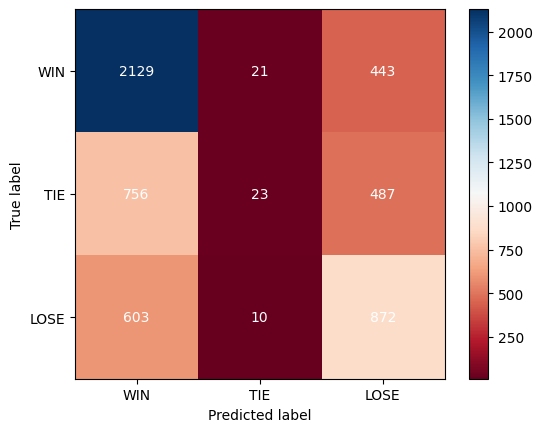

              precision    recall  f1-score   support

           1       0.61      0.82      0.70      2593
           2       0.43      0.02      0.03      1266
           3       0.48      0.59      0.53      1485

    accuracy                           0.57      5344
   macro avg       0.51      0.48      0.42      5344
weighted avg       0.53      0.57      0.50      5344



In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

rf = best_rf
y_pred = rf.predict(X_test)
#Confusion matrix display
labels_=['WIN', 'TIE', 'LOSE']
cm_rf = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,display_labels=labels_)
disp_rf.plot(cmap='RdBu')
for text in disp_rf.text_:
    for t in text:
        t.set_color('white')
plt.show()

print((classification_report(y_test, y_pred)))

## Model Conclusion:
### Random forest model is the best with an accuracy of 0.57

## 3. Prediction

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#rf = RandomForestClassifier(max_depth=7, random_state=0).fit(X_train, y_train)
#y_pred = rf.predict(X_test)

**3.1. "Match_pred" function definition**

In [36]:
def Match_pred (df, model):
    for i in list(df.index):
        df.loc[i,'dif_inter_match']=countries.loc[df.loc[i,'home_team'],'inter_match']-\
        countries.loc[df.loc[i,'away_team'],'inter_match']

        df.loc[i,'dif_inter_match_won']=countries.loc[df.loc[i,'home_team'],'inter_match_won']-\
        countries.loc[df.loc[i,'away_team'],'inter_match_won']

        df.loc[i,'dif_inter_match_lost']=countries.loc[df.loc[i,'home_team'],'inter_match_lost']-\
        countries.loc[df.loc[i,'away_team'],'inter_match_lost']

        df.loc[i,'dif_inter_match_tie']=countries.loc[df.loc[i,'home_team'],'inter_match_tied']-\
        countries.loc[df.loc[i,'away_team'],'inter_match_tied']

        df.loc[i,'dif_inter_goals_sco']=countries.loc[df.loc[i,'home_team'],'inter_goals_sco']-\
        countries.loc[df.loc[i,'away_team'],'inter_goals_sco']

        df.loc[i,'dif_inter_goals_con']=countries.loc[df.loc[i,'home_team'],'inter_goals_con']-\
        countries.loc[df.loc[i,'away_team'],'inter_goals_con']
        df.loc[i,'dif_wc_match']=countries.loc[df.loc[i,'home_team'],'wc_match']-\
        countries.loc[df.loc[i,'away_team'],'wc_match']

        df.loc[i,'dif_wc_match_won']=countries.loc[df.loc[i,'home_team'],'wc_match_won']-\
        countries.loc[df.loc[i,'away_team'],'wc_match_won']

        df.loc[i,'dif_wc_match_lost']=countries.loc[df.loc[i,'home_team'],'wc_match_lost']-\
        countries.loc[df.loc[i,'away_team'],'wc_match_lost']

        df.loc[i,'dif_wc_match_tied']=countries.loc[df.loc[i,'home_team'],'wc_match_tied']-\
        countries.loc[df.loc[i,'away_team'],'wc_match_tied']

        df.loc[i,'dif_wc_goals_sco']=countries.loc[df.loc[i,'home_team'],'wc_goals_sco']-\
        countries.loc[df.loc[i,'away_team'],'wc_goals_sco']

        df.loc[i,'dif_wc_goals_con']=countries.loc[df.loc[i,'home_team'],'wc_goals_con']-\
        countries.loc[df.loc[i,'away_team'],'wc_goals_con']

    df['wcm']=1
    df=df[['home_team', 'away_team', 'wcm',
       'dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost',
       'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con',
       'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost',
       'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con']]

    X=df.drop(columns=['home_team', 'away_team'], axis=1)
    y_pred = model.predict(np.array(X))
    X['home_pred']=y_pred
    X.home_pred=X.home_pred.map({1:"Win",2:"Tie",3:"Lose"})

    return X.home_pred


**3.2. Stage Matches Prediction**

**3.2.1. Group stage matches prediction**

In [37]:
stages=matches_2022[matches_2022['stage']=='Group stage']
stages=stages[['stage','home_team','away_team']]
stages.head()

,stage,home_team,away_team
0,Group stage,Qatar,Ecuador
1,Group stage,Senegal,Netherlands
2,Group stage,England,Iran
3,Group stage,United States,Wales
4,Group stage,France,Australia


In [38]:
#Match predictions
y_pred=Match_pred(stages[['home_team','away_team']], rf)

In [39]:
stages['home_pred']=y_pred

stages.head()

,stage,home_team,away_team,home_pred
0,Group stage,Qatar,Ecuador,Win
1,Group stage,Senegal,Netherlands,Lose
2,Group stage,England,Iran,Win
3,Group stage,United States,Wales,Win
4,Group stage,France,Australia,Win


In [40]:
#Add group column to the stage group matches
ranking_2022.index=ranking_2022.team
stages['group'] = stages['home_team'].map(lambda x: ranking_2022.loc[x, 'group'])
stages.head()

,stage,home_team,away_team,home_pred,group
0,Group stage,Qatar,Ecuador,Win,A
1,Group stage,Senegal,Netherlands,Lose,A
2,Group stage,England,Iran,Win,B
3,Group stage,United States,Wales,Win,B
4,Group stage,France,Australia,Win,D


In [41]:
stages=stages[['group','home_team','away_team','home_pred']]
stages.head()


,group,home_team,away_team,home_pred
0,A,Qatar,Ecuador,Win
1,A,Senegal,Netherlands,Lose
2,B,England,Iran,Win
3,B,United States,Wales,Win
4,D,France,Australia,Win


In [42]:
#Away prediction: opposite of home
stages['away_pred']=stages.home_pred.map({'Win':"Lose",'Tie':'Tie','Lose':'Win'})
stages.head()

,group,home_team,away_team,home_pred,away_pred
0,A,Qatar,Ecuador,Win,Lose
1,A,Senegal,Netherlands,Lose,Win
2,B,England,Iran,Win,Lose
3,B,United States,Wales,Win,Lose
4,D,France,Australia,Win,Lose


In [43]:
# Creating DataFrames for home and away teams
home = stages[['home_team', 'home_pred']]
away = stages[['away_team', 'away_pred']]

# Mapping points for home and away teams
home['pts'] = home['home_pred'].map({'Win': 3, 'Tie': 1, 'Lose': 0})
away['pts'] = away['away_pred'].map({'Win': 3, 'Tie': 1, 'Lose': 0})

# Grouping and summing points for each team
gr_tbl=ranking_2022.drop('fifa_ranking',axis=1)

for i in list(gr_tbl.index):
    gr_tbl.loc[i,'pts']=home.loc[home['home_team']==i,'pts'].sum()+away.loc[away['away_team']==i,'pts'].sum()
    gr_tbl.loc[i,'fifa_ranking']=ranking_2022.loc[i,'fifa_ranking']
gr_tbl=gr_tbl.sort_values(['group','pts', 'fifa_ranking'], ascending=[True,False,True])
gr_tbl.style.set_caption('Group stage finish')



,group,team,pts,fifa_ranking
team,,,,
Netherlands,A,Netherlands,9.000000,8.000000
Qatar,A,Qatar,6.000000,50.000000
Ecuador,A,Ecuador,3.000000,44.000000
Senegal,A,Senegal,0.000000,18.000000
England,B,England,9.000000,5.000000
Iran,B,Iran,6.000000,20.000000
United States,B,United States,3.000000,16.000000
Wales,B,Wales,0.000000,19.000000
Argentina,C,Argentina,9.000000,3.000000


In [44]:
# Winners of group phase
firsts = []
seconds = []

for g in gr_tbl['group'].unique():
    group_teams = gr_tbl.loc[gr_tbl['group'] == g, 'team'].tolist()
    firsts.append(group_teams[0])
    if len(group_teams) > 1:
        seconds.append(group_teams[1])

# Creating DataFrame for group winners
grp_wins = pd.DataFrame({
    'group': gr_tbl['group'].unique(),
    '1': firsts,
    '2': seconds
})

grp_wins.style.set_caption('Winners of group phase')


,group,1,2
0,A,Netherlands,Qatar
1,B,England,Iran
2,C,Argentina,Mexico
3,D,France,Denmark
4,E,Germany,Spain
5,F,Belgium,Croatia
6,G,Brazil,Switzerland
7,H,Uruguay,South Korea


In [45]:
# Adding 'ht' and 'at' columns to grp_wins
grp_wins['ht'] = '1' + grp_wins['group']
grp_wins['at'] = '2' + grp_wins['group']

grp_wins

,group,1,2,ht,at
0,A,Netherlands,Qatar,1A,2A
1,B,England,Iran,1B,2B
2,C,Argentina,Mexico,1C,2C
3,D,France,Denmark,1D,2D
4,E,Germany,Spain,1E,2E
5,F,Belgium,Croatia,1F,2F
6,G,Brazil,Switzerland,1G,2G
7,H,Uruguay,South Korea,1H,2H


**3.2.2. Round of 16 matches prediction**

In [46]:
# Round of 16
round_16 = matches_2022[matches_2022.stage == 'Round of 16'][['stage', 'home_team', 'away_team']]
round_16.index = round_16.index + 1

round_16

,stage,home_team,away_team
49,Round of 16,1A,2B
50,Round of 16,1C,2D
51,Round of 16,1B,2A
52,Round of 16,1D,2C
53,Round of 16,1E,2F
54,Round of 16,1G,2H
55,Round of 16,1F,2E
56,Round of 16,1H,2G


In [47]:
import itertools
home_t=[]
away_t=[]
for i in list(round_16.index):
    home_t.append(grp_wins.loc[grp_wins['ht']==round_16.loc[i,'home_team']  , "1"].to_list())
    away_t.append(grp_wins.loc[grp_wins['at']==round_16.loc[i,'away_team']  , "2"].to_list())
home_t=list(itertools.chain(*home_t))
away_t=list(itertools.chain(*away_t))
round_16['home_t']=home_t
round_16['away_t']=away_t
round_16 = round_16.rename(columns={'home_team':'ht',
                                   'away_team':"at",
                                   'home_t':"home_team",
                                  'away_t':'away_team'})
round_16

,stage,ht,at,home_team,away_team
49,Round of 16,1A,2B,Netherlands,Iran
50,Round of 16,1C,2D,Argentina,Denmark
51,Round of 16,1B,2A,England,Qatar
52,Round of 16,1D,2C,France,Mexico
53,Round of 16,1E,2F,Germany,Croatia
54,Round of 16,1G,2H,Brazil,South Korea
55,Round of 16,1F,2E,Belgium,Spain
56,Round of 16,1H,2G,Uruguay,Switzerland


In [48]:
y_pred = Match_pred(round_16[['home_team','away_team']], rf)

round_16['home_pred']=y_pred

round_16=round_16[['home_team','away_team','home_pred']]
round_16

,home_team,away_team,home_pred
49,Netherlands,Iran,Win
50,Argentina,Denmark,Win
51,England,Qatar,Win
52,France,Mexico,Win
53,Germany,Croatia,Win
54,Brazil,South Korea,Win
55,Belgium,Spain,Lose
56,Uruguay,Switzerland,Win


In [49]:
#Agregar la condicion Tie
round_16['Winner'] = round_16['home_team'].where(round_16['home_pred'] == 'Win', round_16['away_team'])
round_16['wm'] = 'W' + round_16.index.astype(str)
round_16.style.set_caption('Round of 16')


,home_team,away_team,home_pred,Winner,wm
49,Netherlands,Iran,Win,Netherlands,W49
50,Argentina,Denmark,Win,Argentina,W50
51,England,Qatar,Win,England,W51
52,France,Mexico,Win,France,W52
53,Germany,Croatia,Win,Germany,W53
54,Brazil,South Korea,Win,Brazil,W54
55,Belgium,Spain,Lose,Spain,W55
56,Uruguay,Switzerland,Win,Uruguay,W56


**3.2.3. Quarter final matches prediction**


In [50]:
quarter_finals = matches_2022[matches_2022['stage'] == 'Quarter-finals'][['stage', 'home_team', 'away_team']]
quarter_finals.rename(columns={'home_team': 'ht', 'away_team': 'at'}, inplace=True)

quarter_finals.index = quarter_finals.index + 1

quarter_finals

,stage,ht,at
57,Quarter-finals,W49,W50
58,Quarter-finals,W53,W54
59,Quarter-finals,W51,W52
60,Quarter-finals,W55,W56


In [51]:
for i in quarter_finals.index:
    home_winner = round_16.loc[round_16['wm'] == quarter_finals.loc[i, 'ht'], 'Winner'].values[0]
    away_winner = round_16.loc[round_16['wm'] == quarter_finals.loc[i, 'at'], 'Winner'].values[0]

    quarter_finals.at[i, 'home_team'] = home_winner
    quarter_finals.at[i, 'away_team'] = away_winner
    quarter_finals.at[i, 'wm'] = "W" + str(i)


In [52]:
quarter_finals['home_pred']=Match_pred(quarter_finals[['home_team','away_team']], rf)

for i in list(quarter_finals.index):
    if quarter_finals.loc[i,'home_pred']=="Win":
        quarter_finals.loc[i,'Winner']=quarter_finals.loc[i,'home_team']
        quarter_finals.loc[i,'wm']="W"+str(i)

    elif quarter_finals.loc[i,'home_pred']=="Lose":
        quarter_finals.loc[i,'Winner']=quarter_finals.loc[i,'away_team']
        quarter_finals.loc[i,'wm']="W"+str(i)
    else:
        pass
quarter_finals.style.set_caption('Quarter finals')

,stage,ht,at,home_team,away_team,wm,home_pred,Winner
57,Quarter-finals,W49,W50,Netherlands,Argentina,W57,Win,Netherlands
58,Quarter-finals,W53,W54,Germany,Brazil,W58,Win,Germany
59,Quarter-finals,W51,W52,England,France,W59,Win,England
60,Quarter-finals,W55,W56,Spain,Uruguay,W60,Win,Spain



**3.2.4. Semi finals matches prediction**

In [53]:
## Semi finales

semi_finals=matches_2022[matches_2022['stage']=='Semi-finals']

semi_finals=semi_finals.rename(columns={'home_team':'ht', 'away_team':"at"})
semi_finals=semi_finals.drop(['id', 'year','date','host_team'],axis=1)

semi_finals.index = semi_finals.index + 1
semi_finals

,stage,ht,at
61,Semi-finals,W57,W58
62,Semi-finals,W59,W60


In [54]:
for i in semi_finals.index:
    home_winner = quarter_finals.loc[quarter_finals['wm'] == semi_finals.loc[i, 'ht'], 'Winner'].iloc[0]
    away_winner = quarter_finals.loc[quarter_finals['wm'] == semi_finals.loc[i, 'at'], 'Winner'].iloc[0]

    semi_finals.at[i, 'home_team'] = home_winner
    semi_finals.at[i, 'away_team'] = away_winner
    semi_finals.at[i, 'wm'] = "L" + str(i)
semi_finals

,stage,ht,at,home_team,away_team,wm
61,Semi-finals,W57,W58,Netherlands,Germany,L61
62,Semi-finals,W59,W60,England,Spain,L62


In [55]:
semi_finals['home_pred']=Match_pred(semi_finals[['home_team','away_team']],rf)

for i in list(semi_finals.index):
    if semi_finals.loc[i,'home_pred']=="Win":
        semi_finals.loc[i,'Winner']=semi_finals.loc[i,'home_team']
        semi_finals.loc[i,'Losser']=semi_finals.loc[i,'away_team']
        semi_finals.loc[i,'lm']="L"+str(i)
        semi_finals.loc[i,'wm']="W"+str(i)
    elif semi_finals.loc[i,'home_pred']=="Lose":
        semi_finals.loc[i,'Winner']=semi_finals.loc[i,'away_team']
        semi_finals.loc[i,'Losser']=semi_finals.loc[i,'home_team']
        semi_finals.loc[i,'lm']="L"+str(i)
        semi_finals.loc[i,'wm']="W"+str(i)
    else:
        pass
semi_finals.style.set_caption('Semi Final')

,stage,ht,at,home_team,away_team,wm,home_pred,Winner,Losser,lm
61,Semi-finals,W57,W58,Netherlands,Germany,W61,Lose,Germany,Netherlands,L61
62,Semi-finals,W59,W60,England,Spain,W62,Win,England,Spain,L62


**3.2.5. Third place match prediction**


In [56]:
# Third place
third_plc = matches_2022[matches_2022['stage'] == 'Third place']

third_plc = third_plc.rename(columns={'home_team': 'ht', 'away_team': "at"})
third_plc = third_plc.drop(['id', 'year', 'date', 'host_team'], axis=1)

third_plc.index = third_plc.index + 1

third_plc

,stage,ht,at
63,Third place,L61,L62


In [57]:
for i in list(third_plc.index):
    third_plc.loc[i, 'home_team'] = (semi_finals.loc[semi_finals['lm'] == third_plc.loc[i, 'ht'], 'Losser'].to_string().split('    ')[1])
    third_plc.loc[i, 'away_team'] = (semi_finals.loc[semi_finals['lm'] == third_plc.loc[i, 'at'], 'Losser'].to_string().split('    ')[1])
third_plc

,stage,ht,at,home_team,away_team
63,Third place,L61,L62,Netherlands,Spain


In [58]:
third_plc['home_pred'] = Match_pred(third_plc[['home_team', 'away_team']], rf)

for i in list(third_plc.index):
    if third_plc.loc[i, 'home_pred'] == "Win":
        third_plc.loc[i, 'Winner'] = third_plc.loc[i, 'home_team']
        third_plc.loc[i, 'wm'] = "W" + str(i)
    elif third_plc.loc[i, 'home_pred'] == "Lose":
        third_plc.loc[i, 'Winner'] = third_plc.loc[i, 'away_team']
        third_plc.loc[i, 'wm'] = "W" + str(i)
    else:
        pass
third_plc.style.set_caption('Third match')

,stage,ht,at,home_team,away_team,home_pred,Winner,wm
63,Third place,L61,L62,Netherlands,Spain,Win,Netherlands,W63


**3.2.6. Final match prediction**




In [59]:
#Final
final = matches_2022[matches_2022.stage == 'Final']
final = final.rename(columns={'home_team': 'ht', 'away_team': 'at'})
final = final.drop(['id', 'year', 'date', 'host_team'], axis=1)

final.index = final.index + 1

final

,stage,ht,at
64,Final,W61,W62


In [60]:
for i in list(final.index):
    final.loc[i, 'home_team'] = (semi_finals.loc[semi_finals['wm'] == final.loc[i, 'ht'], 'Winner'].to_string().split('    ')[1])
    final.loc[i, 'away_team'] = (semi_finals.loc[semi_finals['wm'] == final.loc[i, 'at'], 'Winner'].to_string().split('    ')[1])

final

,stage,ht,at,home_team,away_team
64,Final,W61,W62,Germany,England


In [61]:
final['home_pred'] = Match_pred(final[['home_team', 'away_team']], rf)

for i in list(final.index):
    if final.loc[i, 'home_pred'] == "Win":
        final.loc[i, 'Winner'] = final.loc[i, 'home_team']

    elif final.loc[i, 'home_pred'] == "Lose":
        final.loc[i, 'Winner'] = final.loc[i, 'away_team']

    else:
        pass

final.style.set_caption('Final')

,stage,ht,at,home_team,away_team,home_pred,Winner
64,Final,W61,W62,Germany,England,Win,Germany
